## Problem 1
Using this information, formulate a multi-armed bandit problem. Your goal should be to achieve the lowest regret possible over the time window given (number of rounds, i.e, columns).

In [1]:
# read data
import pandas as pd
import random
import numpy as np
import time
data = pd.read_csv('yahoo_ad_clicks.csv',header = None)
kt = data.shape # 50 ads; 32657 rounds
k = kt[0]
T = kt[1]
print("k",k)
print("T",T)
data = np.array(data)

k 50
T 32657


## Problem 2
Design a strategy to solve your multi-armed bandit problem with only partial feed- back. In other words, you may only observe the reward for the category of ad you choose to serve at any given time. You may use any methods we have seen so far in the course to solve this problem.

In [2]:
## e-greedy
import math
def e_greedy(data):
    kt = data.shape
    k = kt[0]
    T = kt[1]
    chosen_count = np.zeros(k)
    reward_count = np.zeros(k)
    exp = np.zeros(k)
    actual_mu = []
    for t in range(0,T):
        ## In the first range, explore more
        e = 1/np.log(t+5)
        p = np.random.uniform(0,1)
        if p <= e:         
            idx = np.random.randint(0,50) ## explore
        else:            
            idx = np.argmax(exp) ## exploit
        reward = data[idx,t]
        chosen_count[idx] += 1
        if reward == 1:
            reward_count[idx] += 1
        exp[idx] = reward_count[idx]/chosen_count[idx]
        actual_mu.append(exp[idx])  
    # calculate regret
    best_miu = exp[np.argmax(exp)]
    diff_miu = 0
    regret = []
    for t in range(0,T):
        diff_miu += (best_miu-actual_mu[t])
        regret.append(diff_miu/(t+1))
    return regret, np.sum(reward_count,axis = 0)

In [3]:
regret_egreedy, reward_egreedy = e_greedy(data)

In [4]:
reward_egreedy

9589.0

In [5]:
## define a function to calculate bonus in each round
def calculate_bonus(r, ads, chosen_count): ## r means the round, ads means the advertisement
    if chosen_count[ads] == 0:
        return 1
    else:
        return np.sqrt(2 * np.log(r) / chosen_count[ads])
    
def try_all_ad_once(data):
    kt = data.shape
    k = kt[0]
    T = kt[1]
    ## Getting the initial estimated_miu
    estimated_miu = np.zeros(k)
    prob = np.sum(data[:,T-k:],axis=1)/k
    for i in range(k):
        ## The probability that this row becomes 1
        estimated_miu[i] = np.random.binomial(n=1, p=prob[i])
    return estimated_miu

## Starting UCB algorithm
def UCB1(data):   
    kt = data.shape
    k = kt[0]
    T = kt[1]
    chosen_count = np.ones(k)
    reward_count = np.zeros(k)
    exp = np.zeros(k)
    total_reward = 0
    best_loss = 0
    actual_loss = 0
    estimated_miu = try_all_ad_once(data)
    actual_miu = []
    for t in range(1,(T-k+1)):
        ## Calculate each ad's value of ucb
        upper_bound_probs = [estimated_miu[item] + calculate_bonus(t, item, chosen_count) for item in range(k)]
        ## Pick the ad who has max value
        ad = np.argmax(upper_bound_probs)
        ## Observe the rewards (not sure), reward is 0 or 1.
        reward = data[:,t][ad]
        ## Updating the counts of the ad selected
        chosen_count[ad] += 1
        ## Updating the estimated value the ad selected
        estimated_miu[ad] = ((chosen_count[ad]-1)*estimated_miu[ad]+reward)/chosen_count[ad]
        actual_miu.append(estimated_miu[ad])
        ## Recording the number of rewards
        total_reward += reward
        if reward == 1:
            reward_count[ad] += 1
        exp[ad] = reward_count[ad]/chosen_count[ad]
    ## Calculating regret using miu
    best_miu = exp[np.argmax(exp)]
    dif_miu = 0
    regret = []
    for t in range(1,T-k+1):
        dif_miu += best_miu - actual_miu[t-1]
        regret.append(dif_miu/t)
    return regret,total_reward

In [6]:
regret_ucb1,reward_ucb1 = UCB1(data)

In [7]:
reward_ucb1

10155

In [8]:
# Thompson
def thompson(data):
    kt = data.shape
    k = kt[0]
    T = kt[1]
    S = [0]*k
    F = [0]*k
    beta = []
    reward = 0
    chosen_count = np.ones(k)
    reward_count = np.zeros(k)
    best_arm = np.argmax(np.sum(data,axis=1))
    best_loss = 0
    actual_loss = 0
    regret = []
    actual_miu = []
    for t in range(0,T):
        # select ad
        theta_t = []
        for i in range(0,k):
            theta_t.append(np.random.beta(S[i]+1,F[i]+1))
        chosen_arm = np.argmax(theta_t)
        
        this_reward = data[chosen_arm,t]
        reward += this_reward
        if(this_reward == 1):
            S[chosen_arm] += 1
        else:
            F[chosen_arm] += 1
        actual_miu.append(S[chosen_arm]/(S[chosen_arm] + F[chosen_arm]))
    dif_miu = 0
    best_idx = np.argmax(np.array(S)/(np.array(S)+np.array(F)))
    best_miu = np.array(S[best_idx])/(np.array(S[best_idx])+np.array(F[best_idx]))
    for t in range(0,T):
        dif_miu += best_miu - actual_miu[t]
        regret.append(dif_miu/(t+1))       
    return regret,reward

In [9]:
regret_thompson,reward_thompson = thompson(data)

In [10]:
reward_thompson

11025

In [13]:
from random import choices
def exp3(data):
    kt = data.shape # 50 ads; 32657 rounds
    k = kt[0]
    T = kt[1]
    ita_t = list(map(lambda x: np.sqrt(np.log(k)/(k*x)), range(1,T+1)))
    p_t = [1/k]*k
    L = [0]*k
    cumu_L = [0]*k
    reward = 0
    regret = []
    dif_loss = 0
    best_loss = 0
    actual_loss = 0
    for t in range(0,T):
        chosen_arm = choices(range(0,k),p_t)[0]
        cumu_L += 1 - data[:,t]
        best_arm = np.argmin(cumu_L)
        this_reward = data[chosen_arm,t]
        reward += this_reward
        actual_loss += 1 - data[chosen_arm,t]
        best_loss = cumu_L[best_arm]
        
        dif_loss = actual_loss - best_loss
        regret.append(dif_loss/(t+1)) 
        
        l_it_hat = (1 - data[chosen_arm,t])/p_t[chosen_arm]
        L[chosen_arm] += l_it_hat
        # update p_t
        vec = np.exp(-ita_t[t]*np.array(L))
        p_t = vec/sum(vec)
    return regret,reward

In [14]:
regret_exp3, reward_exp3 = exp3(data)

In [15]:
reward_exp3

9518

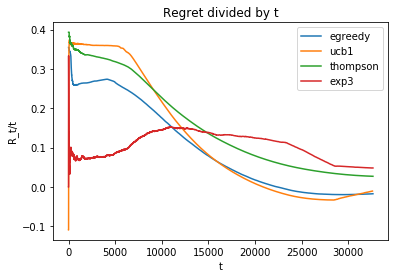

In [17]:
from matplotlib import pyplot as plt     
plt.plot(range(1,T+1),regret_egreedy)
plt.plot(range(1,T-k+1),regret_ucb1)
plt.plot(range(1,T+1),regret_thompson)
plt.plot(range(1,T+1),regret_exp3)
plt.legend(labels = ['egreedy','ucb1','thompson','exp3'], loc = 'best')
plt.xlabel('t')
plt.ylabel('R_t/t')
plt.title("Regret divided by t")
plt.show()

## Problem 3
Design a strategy to solve your multi-armed bandit problem with full feedback, i.e., with observing all rewards after you serve an ad. Compare the regret you experience here with the regret from Problem 2, and comment on it.

In [18]:
# multiplicative weight updates (full feedback)
def multiWeight(data):
    kt = data.shape # 50 ads; 32657 rounds
    k = kt[0]
    T = kt[1]
    ita_t = 1/np.sqrt(T)
    p_t = [0]*k
    w = [1]*k
    cumu_L = [0]*k
    reward = 0
    regret = []
    dif_loss = 0
    best_loss = 0
    actual_loss = 0
    for t in range(0,T):
        p_t = np.divide(w,sum(w))
        chosen_arm = choices(range(0,k),p_t)[0]
        cumu_L += 1 - data[:,t]
        best_arm = np.argmin(cumu_L)
        this_reward = data[chosen_arm,t]
        reward += this_reward
     
        actual_loss += 1 - data[chosen_arm,t]
        best_loss = cumu_L[best_arm]
        
        dif_loss = actual_loss - best_loss
        regret.append(dif_loss/(t+1))  
        
        # observe the costs of decisions L at that round
        L = 1 - data[:,t]
        # penalize the costly decisions by updating their weights as follows
        w = np.multiply(w,(1-ita_t*np.array(L)))
    return regret, reward

In [19]:
regret_multiw, reward_multiw = multiWeight(data)

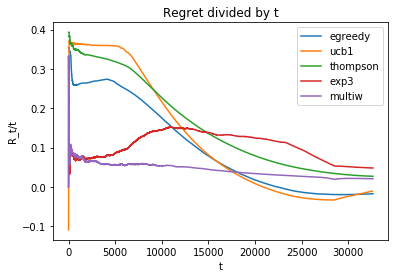

In [20]:
# regret
from matplotlib import pyplot as plt     
plt.plot(range(1,T+1),regret_egreedy)
plt.plot(range(1,T-k+1),regret_ucb1)
plt.plot(range(1,T+1),regret_thompson)
plt.plot(range(1,T+1),regret_exp3)
plt.plot(range(1,T+1),regret_multiw)
plt.legend(labels = ['egreedy','ucb1','thompson','exp3','multiw'], loc = 'best')
plt.xlabel('t')
plt.ylabel('R_t/t')
plt.title("Regret divided by t")
plt.show()

## Problem 4
The 3 groups with the smallest regret for partial feedback will receive bonus points. To receive these bonus points you must fully explain your implementation, why you used it and any parameters you chose, and cannot use knowledge about the structure of the data.

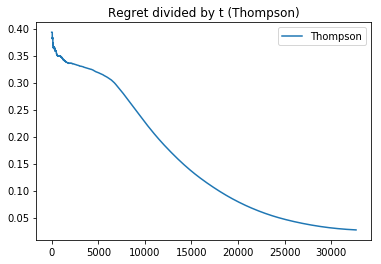

In [21]:
plt.plot(range(1,T+1),regret_thompson)
plt.legend(labels = ['Thompson'], loc = 'best')
plt.title("Regret divided by t (Thompson)")
plt.show()